In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the CSV file
df = pd.read_csv('1C8RuvGfRsX1fmxaehox9K_songs.csv')


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Selecting features for clustering
features = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness',
            'Instrumentalness', 'Liveness', 'Valence', 'Tempo']

# Preprocessing: Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df[features])

# Clustering with KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
df['Mood Cluster'] = kmeans.fit_predict(features_scaled)

# Dimensionality Reduction for Visualization (2D)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]
print(df.head())

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df['PCA1'], df['PCA2'], c=df['Mood Cluster'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(label='Mood Cluster')
plt.title('Mood-Based Clustering of Songs')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Annotate with song names
for i, song in enumerate(df['Song Name']):
    plt.annotate(song, (df['PCA1'][i], df['PCA2'][i]), fontsize=8)

plt.show()

In [ ]:
# Drop the Song Name, Artist, and URL columns
df = df.drop(['Song Name', 'Artist', 'Cover Image URL'], axis=1)

# Add a new column for the correlated song images and import the images from the track_images folder
df['Image'] = [f'track_images/{i}.jpg' for i in df['ID']]


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

#Keep original copy of the audio features dataframe
df_original = df.copy()

#Drop the PCA1 and PCA2 columns 
df = df.drop(['PCA1', 'PCA2', 'Mood Cluster'], axis=1)

#Remove the Image column but save in its own dataframe
df_images = df['Image']
df = df.drop('Image', axis=1)


from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

#Read in song lyric data 
df_lyrics = pd.read_csv('song_lyrics.csv')
df_lyrics = df_lyrics.rename(columns={'track_id': 'ID'})

#Delete Track_name and Artist_Columns
df_lyrics = df_lyrics.drop(['track_name', 'track_artist'], axis=1)

# Tokenizing the lyrics for Word2Vec
df_lyrics['tokens'] = df_lyrics['lyrics'].dropna().apply(lambda x: word_tokenize(x.lower()))

# Word2Vec Model(Captures semantic meaning and context): Train on tokenized lyrics
w2v_model = Word2Vec(sentences=df_lyrics['tokens'], vector_size=300, window=5, min_count=1, workers=4)
w2v_vectors = {word: w2v_model.wv[word] for word in w2v_model.wv.index_to_key}

# For each song, calculate the average vector of all word vectors in the lyrics
def average_vectors(lyrics):
    vector = np.mean([w2v_vectors.get(word, np.zeros(300)) for word in lyrics.split()], axis=0)
    return vector

df_lyrics['lyrics_vector'] = df_lyrics['lyrics'].apply(average_vectors)

# Merge the lyrics vector back into the main DataFrame
df = pd.merge(df, df_lyrics[['ID', 'lyrics_vector']], on='ID')

#save df to a CSV file
df.to_csv('df.csv', index=True)

print(df.head())

# Standardize audio features
scaler = StandardScaler()
audio_features = scaler.fit_transform(df[['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']])

# Convert lyrics vectors to an array format for concatenation
lyrics_vectors = np.array(df['lyrics_vector'].tolist())

# Combine audio features with lyrics vectors
combined_features = np.concatenate([audio_features, lyrics_vectors], axis=1)
final_df = pd.DataFrame(combined_features)

##Save final_df to a CSV file
final_df.to_csv('final_dataset.csv', index=False)

# Display the structured dataset for verification
print(final_df.head())

print("Shape of final dataset:", final_df.shape)
#Shape = (100, 309) --> This confirms you have 100 songs, each with a combined feature vector length of 309 (9 audio features + 300 Word2Vec vector).

print("Summary of features in final_df:")
print(final_df.describe())

sample_index = 0  # Change as needed
print("Sample row:", final_df.iloc[sample_index])

# Display first few columns to verify audio features
print("First 10 columns (audio features):")
print(final_df.iloc[:, :10].head())

# Display some of the Word2Vec vector columns for lyrics
print("Sample lyrics vector columns:")
print(final_df.iloc[:, 10:20].head())

In [ ]:
##BASIC GAN
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, GaussianNoise, Reshape, Conv2DTranspose, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os


tf.get_logger().setLevel('ERROR')

# Suppress TensorFlow logs (only show errors)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

final_features = final_df.values 

# Step 1: Load and Preprocess Images
#Resizes and normalizes album cover images to a shape of (64, 64, 3) with pixel values in the range [-1, 1].
def load_and_preprocess_images(df_images, target_size=(64, 64)):
    images = []
    for path in df_images:
        if os.path.exists(path):  # Check if the file exists
            img = Image.open(path).resize(target_size)
            img = img.convert("RGB")  # Convert grayscale to RGB
            img = np.array(img) / 127.5 - 1  # Normalize to range [-1, 1]
            images.append(img)
        else:
            print(f"Warning: Image file not found at {path}. Skipping this file.")
            # Optionally, add a placeholder (e.g., a black image) to keep alignment
            images.append(np.zeros((target_size[0], target_size[1], 3)))
    return np.array(images)

# Assuming `df_images` contains paths to album cover images
real_images = load_and_preprocess_images(df_images) 

# Step 2: Build the GAN Components

# Ensure the checkpoint directory exists
os.makedirs("checkpoints", exist_ok=True)

In [ ]:
#The Generator takes in the combined feature vector of size 309 and outputs a generated image of shape (64, 64, 3).

# Generator Model (First Edition)
def build_generator(input_dim):
    model = Sequential([
        Dense(256, input_dim=input_dim),
        LeakyReLU(0.2),
        BatchNormalization(momentum=0.8),
        GaussianNoise(0.05), 
        Dense(512),
        LeakyReLU(0.2),
        BatchNormalization(momentum=0.8),
        GaussianNoise(0.05),
        Dense(1024),
        LeakyReLU(0.2),
        BatchNormalization(momentum=0.8),
        Dense(64 * 64 * 3, activation='tanh'),
        Reshape((64, 64, 3))
    ])
    return model


In [ ]:
# Generator Model (Second Edition)
def build_generator(input_dim):
    model = Sequential([
        Dense(8 * 8 * 512, input_dim=input_dim),
        LeakyReLU(0.2),
        BatchNormalization(momentum=0.8),
        Reshape((8, 8, 512)),  

        UpSampling2D(),
        Conv2D(256, kernel_size=3, padding="same"),
        LeakyReLU(0.2),
        BatchNormalization(momentum=0.8),

        UpSampling2D(),
        Conv2D(128, kernel_size=3, padding="same"),
        LeakyReLU(0.2),
        BatchNormalization(momentum=0.8),

        UpSampling2D(),
        Conv2D(64, kernel_size=3, padding="same"),
        LeakyReLU(0.2),

        Conv2D(3, kernel_size=3, padding="same", activation='tanh')  # Output shape (64, 64, 3)
    ])
    return model





In [ ]:

# Discriminator Model
#The Discriminator takes both the generated (or real) image and the feature vector to conditionally assess if the image is real or fake.
def build_discriminator(img_shape, feature_dim):
    img_input = tf.keras.Input(shape=img_shape)
    feature_input = tf.keras.Input(shape=(feature_dim,))
    
    # Flatten image
    x_img = Flatten()(img_input)
    x = Concatenate()([x_img, feature_input])
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    validity = Dense(1, activation='sigmoid')(x)
    return Model([img_input, feature_input], validity)

# Instantiate and compile models
feature_dim = final_features.shape[1]
img_shape = (64, 64, 3)

generator = build_generator(input_dim=feature_dim)
discriminator = build_discriminator(img_shape=img_shape, feature_dim=feature_dim)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5), metrics=['accuracy'])
discriminator.trainable = False


# Combined GAN Model
z = tf.keras.Input(shape=(feature_dim,))
generated_image = generator(z)
validity = discriminator([generated_image, z])
gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


# Create a directory to save generated images if it doesn't exist
os.makedirs("generated_images", exist_ok=True)

# Paths for saving checkpoints
generator_checkpoint_path = "checkpoints/generator_epoch_{epoch:03d}.h5"
discriminator_checkpoint_path = "checkpoints/discriminator_epoch_{epoch:03d}.h5"

# Function to save generated images
def save_generated_images(generator, epoch, num_images=5):
    random_features = np.random.normal(0, 1, (num_images, final_features.shape[1]))
    generated_images = generator.predict(random_features)

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow((generated_images[i] + 1) / 2)  # Rescale from [-1, 1] to [0, 1]
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_images/epoch_{epoch}.png")
    plt.close()


In [ ]:
# Step 3: Training Loop
#epochs = 5000
epochs = 10000
#epochs = 20000
batch_size = 32
valid = np.ones((batch_size, 1), dtype='float32')  # Ensure dtype is float32
fake = np.zeros((batch_size, 1), dtype='float32')  # Ensure dtype is float32

print("Shape of 'valid':", valid.shape)  # Should print (32, 1)
print("Shape of 'fake':", fake.shape)    # Should print (32, 1)

for epoch in range(epochs):
    print(f"Starting epoch {epoch + 1}/{epochs}")  # Progress check

    # Train Discriminator
    # Discriminator Training: Trains with real and generated images alongside their feature vectors.

    # Select a random batch of real images and corresponding features
    idx = np.random.randint(0, real_images.shape[0], batch_size)
    real_imgs = real_images[idx].astype('float32')   # Ensure dtype is float32
    real_features = final_features[idx].astype('float32')  # Ensure dtype is float32
    
    # Generate fake images
    gen_imgs = generator.predict(real_features)
    
    # Labels for real and fake images
    # Ensure labels are in float32
    valid = np.ones((batch_size, 1), dtype='float32')
    fake = np.zeros((batch_size, 1), dtype='float32')

     # Confirm shapes and data types of all inputs to train_on_batch
    print("Shapes and dtypes before training:")
    print("real_imgs:", real_imgs.shape, real_imgs.dtype)
    print("real_features:", real_features.shape, real_features.dtype)
    print("gen_imgs:", gen_imgs.shape, gen_imgs.dtype)
    print("valid:", valid.shape, valid.dtype, "fake:", fake.shape, fake.dtype)

    # Train the discriminator (real classified as valid, fake as fake)
    d_loss_real = discriminator.train_on_batch([real_imgs, real_features], valid)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, real_features], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train Generator
    # Generator Training: Aims to fool the discriminator by creating images that match the conditional input features.

    # Train the generator to produce images that the discriminator labels as valid
    g_loss = gan.train_on_batch(real_features, valid)
    
    # Print progress
    # Every 50 epochs, the code outputs the loss for both the discriminator and generator, providing insight into training progress.
    if epoch % 50 == 0:
        print(f"Epoch {epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")
        save_generated_images(generator, epoch)
        generator.save_weights(f"checkpoints/generator_epoch_{epoch + 1:03d}.h5")
        discriminator.save_weights(f"checkpoints/discriminator_epoch_{epoch + 1:03d}.h5")
        print(f"Checkpoint saved at epoch {epoch + 1}")
    
    """if epoch % 1000 == 0:
         print(f"Epoch {epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")
        save_generated_images(generator, epoch)
        generator.save_weights(f"checkpoints/generator_epoch_{epoch + 1:03d}.h5")
        discriminator.save_weights(f"checkpoints/discriminator_epoch_{epoch + 1:03d}.h5")
        print(f"Checkpoint saved at epoch {epoch + 1}")"""
    


1/1 [==============================] - 0s 34ms/step


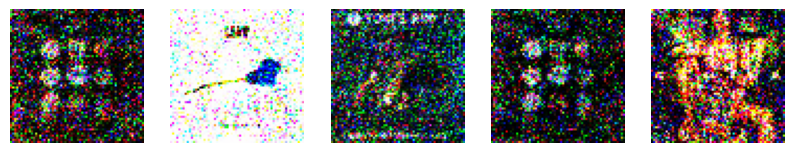

In [28]:
###EPochs = 5000 / First Edition Model 

# Load final generator weights
generator.load_weights('checkpoints/generator_epoch_4951.h5')  # Adjust epoch as needed

# Generate sample images from random input features
sample_features = final_features[:5]  # Use actual feature samples or create random ones
generated_images = generator.predict(sample_features)

# Display generated images
plt.figure(figsize=(10, 2))
for i, img in enumerate(generated_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow((img * 127.5 + 127.5).astype(np.uint8))  # Rescale to [0, 255]
    plt.axis('off')
plt.show()

1/1 [==============================] - 0s 24ms/step


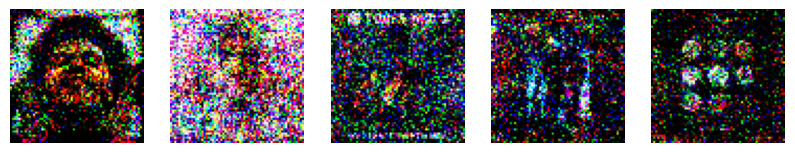

In [29]:
###EPochs = 10000 / First Edition Model 

# Load final generator weights
generator.load_weights('checkpoints/generator_epoch_9951.h5')  # Adjust epoch as needed

# Generate sample images from random input features
sample_features = final_features[:5]  # Use actual feature samples or create random ones
generated_images = generator.predict(sample_features)

# Display generated images
plt.figure(figsize=(10, 2))
for i, img in enumerate(generated_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow((img * 127.5 + 127.5).astype(np.uint8))  # Rescale to [0, 255]
    plt.axis('off')
plt.show()

Shape of average features: (309,)
1/1 [==============================] - 0s 211ms/step


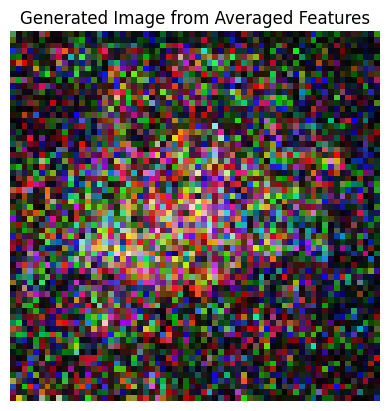

In [31]:
##First Edition Model Result 
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Calculate the average of all feature vectors in the training dataset
# Assuming `final_df` is your training dataset with shape (100, 309)
average_features = np.mean(final_df.values, axis=0)

print("Shape of average features:", average_features.shape)  # Should be (309,)

# Step 2: Feed the averaged features into the generator to produce a new image
# Reshape to match the input shape expected by the generator
average_features_input = np.expand_dims(average_features, axis=0)  # Shape (1, 309)

# Generate the image2
generated_image = generator.predict(average_features_input)

# Step 3: Rescale the generated image from [-1, 1] to [0, 255] for visualization
generated_image = (generated_image[0] * 127.5 + 127.5).astype(np.uint8)

# Step 4: Display the generated image
plt.imshow(generated_image)
plt.axis('off')
plt.title("Generated Image from Averaged Features")
plt.show()

# Optionally, save the generated image
from PIL import Image
generated_image_pil = Image.fromarray(generated_image)
generated_image_pil.save("generated_image_from_average_features.png")


In [ ]:
###EPochs = 20000 / First Edition Model 

# Load final generator weights
generator.load_weights('checkpoints/generator_epoch_19951.h5')  # Adjust epoch as needed

# Generate sample images from random input features
sample_features = final_features[:5]  # Use actual feature samples or create random ones
generated_images = generator.predict(sample_features)

# Display generated images
plt.figure(figsize=(10, 2))
for i, img in enumerate(generated_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow((img * 127.5 + 127.5).astype(np.uint8))  # Rescale to [0, 255]
    plt.axis('off')
plt.show()

In [ ]:
###Epochs = 5000 // Second Edition Generator Model 

# Load final generator weights
generator.load_weights('checkpoints/generator_epoch_4951.h5')  # Adjust epoch as needed

# Generate sample images from random input features
sample_features = final_features[:5]  # Use actual feature samples or create random ones
generated_images = generator.predict(sample_features)

# Display generated images
plt.figure(figsize=(10, 2))
for i, img in enumerate(generated_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow((img * 127.5 + 127.5).astype(np.uint8))  # Rescale to [0, 255]
    plt.axis('off')
plt.show()